<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/Rock_Paper_Scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

dataset, info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)
dataset

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [ ]:
info.features["image"]

Image(shape=(300, 300, 3), dtype=tf.uint8)

In [ ]:
info.splits

{'test': <tfds.core.SplitInfo num_examples=372>,
 'train': <tfds.core.SplitInfo num_examples=2520>}

In [ ]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=2520>

In [ ]:
class_names = info.features["label"].names
class_names

['rock', 'paper', 'scissors']

In [ ]:
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
dataset_size

2520

### Dataset을 Training, Validation, Test set으로 나누어 받기


In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow import keras
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

test_set_raw, valid_set_raw, train_set_raw = tfds.load("rock_paper_scissors",split=["train[:2%]", "train[20%:22%]","train[40%:46%]"])

# Data Augmentation (가운데 자르기 변형)
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]

# Data Augmetation (일부를 랜덤하게 자르기 변형)
def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image,[min_dim,min_dim,3])


In [ ]:
# 데이터를 MNIST 변형 계층에 넣기 위해 dataset prcessing 하는 부분
x_train_set, y_train_set = np.empty((0,300,300,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = central_crop(i['image'].numpy())
  x_train_set = np.append(x_train_set,np.expand_dims(temp, axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,300,300,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = central_crop(i['image'].numpy())
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,300,300,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = central_crop(i['image'].numpy())
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

#### MNIST CNN 변형 모델

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[300, 300, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),
])

#### Central Augmentation fit 진행

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
5/5 [==============================] - 232s 46s/step - loss: 373.4524 - accuracy: 0.2914 - val_loss: 1.2575 - val_accuracy: 0.2600
Epoch 2/10
5/5 [==============================] - 252s 52s/step - loss: 2.5106 - accuracy: 0.3245 - val_loss: 1.0818 - val_accuracy: 0.3000
Epoch 3/10
5/5 [==============================] - 221s 45s/step - loss: 1.3266 - accuracy: 0.3377 - val_loss: 1.0976 - val_accuracy: 0.3200
Epoch 4/10
5/5 [==============================] - 217s 44s/step - loss: 1.0912 - accuracy: 0.3576 - val_loss: 3.8230 - val_accuracy: 0.2600
Epoch 5/10
5/5 [==============================] - 215s 43s/step - loss: 2.6724 - accuracy: 0.3642 - val_loss: 1.1035 - val_accuracy: 0.2600
Epoch 6/10
5/5 [==============================] - 219s 44s/step - loss: 1.5994 - accuracy: 0.3046 - val_loss: 1.1051 - val_accuracy: 0.2600
Epoch 7/10
5/5 [==============================] - 222s 45s/step - loss: 3.0454 - accuracy: 0.3775 - val_loss: 1.1252 - val_accuracy: 0.3200
Epoch 8/10
5/5 [==

In [ ]:
model.evaluate(x_test_set,y_test_set)

2/2 [==============================] - 28s 10s/step - loss: 1.1301 - accuracy: 0.2200


[1.1301418542861938, 0.2199999988079071]

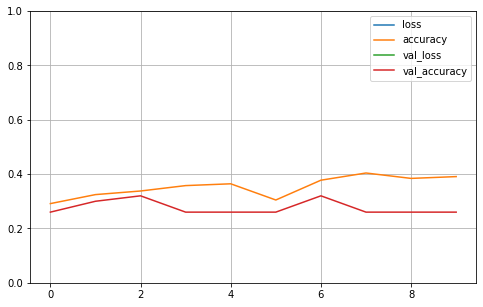

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
test, valid, train = tfds.load("rock_paper_scissors",as_supervised=True,split=["train[:10%]", "train[10%:25%]","train[25%:]"])

# Data Augementation 첫 번째
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]



def preprocess_one(image,label):
  cropped_image = central_crop(image)
  image = tf.cast(cropped_image,tf.float32)
  #image = tf.cast(image, tf.float32)
  image = image/ 255.
  #image = tf.image.resize(image, [INPUT_IMG_SIZE,INPUT_IMG_SIZE])
  return image, label


batch_size = 32
train_set = train.map(partial(preprocess_one)).batch(batch_size).prefetch(1)

# #central_x_train_set = train_set_raw.map(partial(preprocess_one)).batch(batch_size).prefetch(1)
# central_x_valid_set = valid.map(preprocess_one).batch(batch_size).prefetch(1)
# central_x_test_set = test.map(preprocess_one).batch(batch_size).prefetch(1)
#central_x_train_set = train.map(partial(preprocess_one(x_train_set, y_))).batch(batch_size).prefetch(1)


In [ ]:
ds = tfds.as_numpy(train_set)


TypeError: ignored

In [ ]:
count = 1
for ex in ds:
  if count == 1:
    x = ex
    count += 1
  else:
    y =ex
    break

In [ ]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[300,300,3]),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),                                                             
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_set,class_names, epochs=10,callbacks=early_stopping)

ValueError: ignored

TypeError: ignored

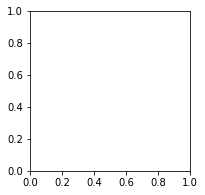

In [ ]:
#1 ~ 59
#0 ~ 33
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from functools import partial

#INPUT_IMG_SIZE = 100

def change_img(image,label):
  image = tf.cast(image, tf.float32)
  image = image/ 255.
  #image = tf.image.resize(image, [INPUT_IMG_SIZE,INPUT_IMG_SIZE])
  return image, label

In [ ]:
# 단순히 이미지를 사용하는 부분
def change_img(image,label):
  image = tf.cast(image, tf.float32)
  image = image/ 255.
  #image = tf.image.resize(image, [INPUT_IMG_SIZE,INPUT_IMG_SIZE])
  return image, label

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Data Augementation 첫 번째
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]



def preprocess_one(image, label):
  cropped_image = central_crop(image)
  image = tf.cast(cropped_image,tf.float32)
  #image = tf.cast(image, tf.float32)
  image = image/ 255.
  #image = tf.image.resize(image, [INPUT_IMG_SIZE,INPUT_IMG_SIZE])
  return image, label

from functools import partial
batch_size = 32

train_set = train_set_raw.map(partial(preprocess_one)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess_one).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess_one).batch(batch_size).prefetch(1)

In [ ]:
# Data Augementation 두 번째
def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image,[min_dim,min_dim,3])



def preprocess_two(image, label):
  cropped_image = random_crop(image)
  cropped_image = tf.image.random_flip_left_right(cropped_image)
  image = tf.cast(cropped_image,tf.float32)
  #image = tf.cast(image, tf.float32)
  image = image/ 255.
  #image = tf.image.resize(image, [INPUT_IMG_SIZE,INPUT_IMG_SIZE])
  return image, label

### 모델 1(Fashion MNIST CNN 변형)

In [ ]:
from functools import partial
batch_size = 32

train_set = train_set_raw.map(partial(change_img)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(change_img).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(change_img).batch(batch_size).prefetch(1)

NameError: ignored

##### 가위 바위 보 데이터 모델

In [ ]:
from functools import partial
import tensorflow as tf
from tensorflow import keras

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=16, kernel_size=7, input_shape=[300,300,3]),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),                                                             
])

##### Data Arugment 1을 수행한 결과

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_set, epochs=10, validation_data=valid_set,callbacks=early_stopping)

Epoch 1/10
60/60 [==============================] - 588s 10s/step - loss: 1.1158 - accuracy: 0.3995 - val_loss: 0.5694 - val_accuracy: 0.8466
Epoch 2/10
60/60 [==============================] - 571s 10s/step - loss: 0.6067 - accuracy: 0.7270 - val_loss: 0.1054 - val_accuracy: 0.9974
Epoch 3/10
60/60 [==============================] - 581s 10s/step - loss: 0.4046 - accuracy: 0.8317 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 4/10
60/60 [==============================] - 580s 10s/step - loss: 0.3309 - accuracy: 0.8698 - val_loss: 0.0234 - val_accuracy: 0.9947
Epoch 5/10
60/60 [==============================] - 578s 10s/step - loss: 0.2517 - accuracy: 0.9127 - val_loss: 0.2840 - val_accuracy: 0.8757
Epoch 6/10
60/60 [==============================] - 588s 10s/step - loss: 0.2687 - accuracy: 0.9021 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 7/10
60/60 [==============================] - 575s 10s/step - loss: 0.3547 - accuracy: 0.8614 - val_loss: 1.8582 - val_accuracy: 0.6587
Epoch 

In [ ]:
model.evaluate(test_set)

8/8 [==============================] - 27s 3s/step - loss: 0.0060 - accuracy: 1.0000


[0.00602998910471797, 1.0]

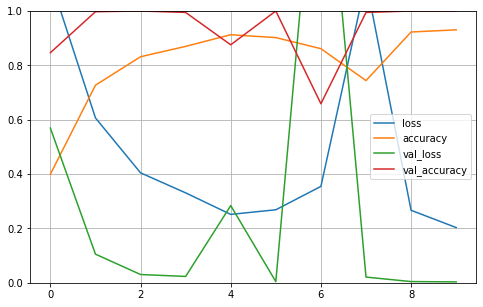

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
#save_fig("keras_learning_curves_plot")
plt.show()

##### Data Arguamnet를 하지 않은 경우

In [ ]:
model.evaluate(test_set)

8/8 [==============================] - 16s 2s/step - loss: 0.2305 - accuracy: 0.9881


[0.230536550283432, 0.988095223903656]

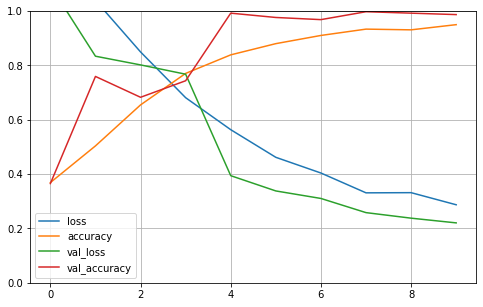

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
#save_fig("keras_learning_curves_plot")
plt.show()

### Xception 사용

In [ ]:
from functools import partial
import tensorflow as tf
from tensorflow import keras


def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]


def preprocess_xception(image,label):
  cropped_image = central_crop(image)
  image = tf.cast(cropped_image,tf.float32)
  image = image/ 255.
  final_image = keras.applications.xception.preprocess_input(image)
  return final_image, label




from functools import partial
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess_xception)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess_xception).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess_xception).batch(batch_size).prefetch(1)

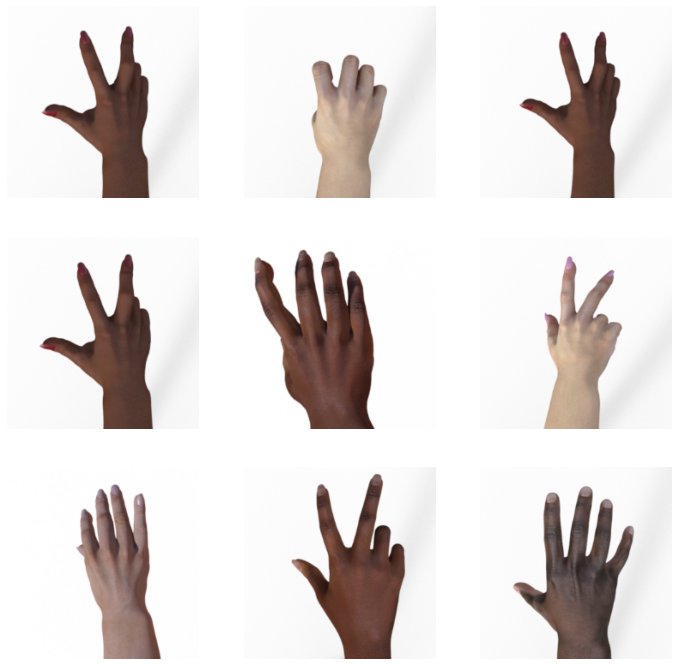

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.axis("off")

plt.show()

In [ ]:
base_model = keras.applications.xception.Xception(weights=None,include_top="False")
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

# for layer in base_model.layers:
#   layer.trainable = False
  
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

ValueError: ignored

### Resnet34 활용

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))